In [1]:
#Importing packages
from transformers import ViTModel, ViTImageProcessor
import torch
from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import numpy as np

#Import library code
import dataloading
import data_vis
import model_functions

c:\Users\Aneesh\anaconda3\envs\test_requirements\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Seed 1234 looks better

#torch.manual_seed(2356)

In [3]:
labels_csv = "camera_data/coronado_hills_binary_10-24-2025.csv"
image_dir = "camera_data/images/"

data = dataloading.get_data(labels_csv=labels_csv, image_dir=image_dir)

In [4]:
train, val, test = dataloading.get_train_val_test(data = data, output_csvs=True)

In [5]:
train_dataset, val_dataset, test_dataset = dataloading.get_datasets(train, val, test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, pin_memory=True)

In [6]:
# Importing the model and setting the device. Using a ViT model since transformer architecture is generally pretty powerful when it comes to extracting features from data.
model_name = "google/vit-base-patch16-224"
vit = ViTModel.from_pretrained(model_name, torch_dtype=torch.float32)
device = "cuda" #Change to cpu if you aren't using a GPU

`torch_dtype` is deprecated! Use `dtype` instead!
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
encoder = model_functions.ViTEmbeddingNet(vit)
encoder.to(device);

In [8]:
encoder.load_state_dict(torch.load('weights/model_weights_camera_10-27-25.pth', weights_only=True))
encoder.eval();

In [9]:
#Get embeddings of the first batch of data
raw_embeddings, labels = model_functions.get_batch_embeddings(encoder, val_dataloader)
embeddings, labels = model_functions.reduce_pca(raw_embeddings, labels)

In [10]:
type(raw_embeddings)

torch.Tensor

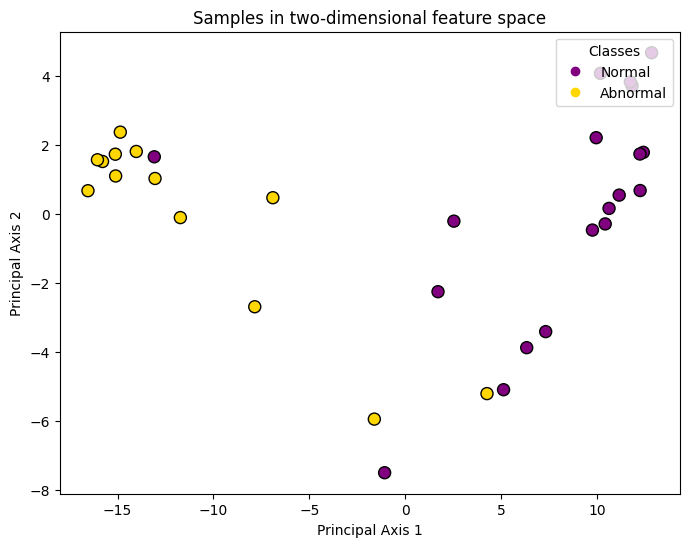

In [11]:
data_vis.plot_data(embeddings, labels)

Accuracy: 0.90625


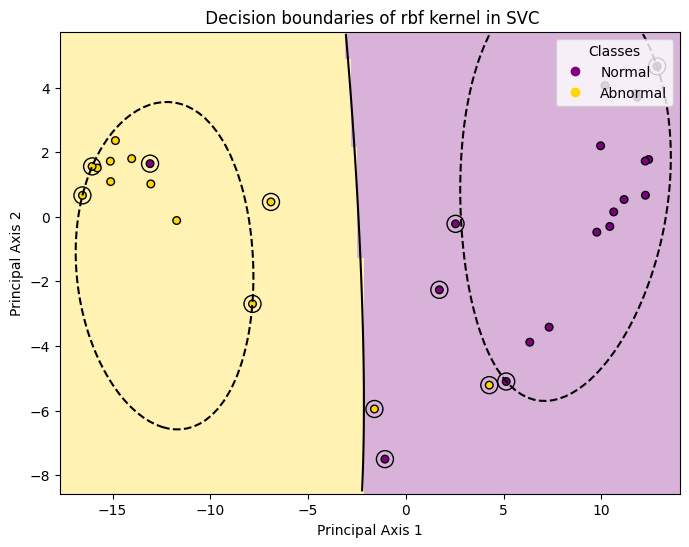

In [12]:
svm_classifier = data_vis.plot_with_decision_boundary("rbf", embeddings, labels)

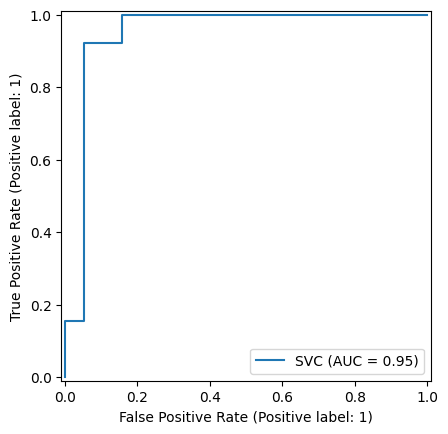

In [13]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_estimator(
   svm_classifier, embeddings, labels)

plt.show()

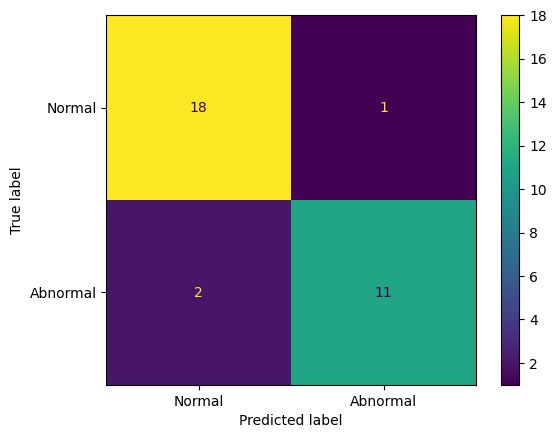

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(svm_classifier, embeddings, labels, display_labels=["Normal", "Abnormal"])